In [782]:
import numpy as np
from qiskit import *
%matplotlib inline
import matplotlib.pyplot as plt
import math
shots = 4096
pi = math.pi

# Algorytm Grovera dla n=3
implementacja bez optymalizacji

### Ilość iteracji
obliczana jest jako liczba całkowita powstała po zaokrągleniu wyniu obliczeń pi/4 * sqrt(2^szer), szer  - ilość bitów rejestru wejściowego

In [783]:
szerokosc = 3
iteracje = (pi/4 * math.sqrt(math.pow(2,szerokosc))).__int__()
print("potrzebna ilość iteracji: {}".format(iteracje))

potrzebna ilość iteracji: 2


### Bramka cccZ

Bramka cccZ zaproponowana przez

PHILIP STRÖMBERG oraz
VERA BLOMKVIST KARLSSON

w pracy

4-qubit Grover’s algorithm
implemented for the ibmqx5
architecture

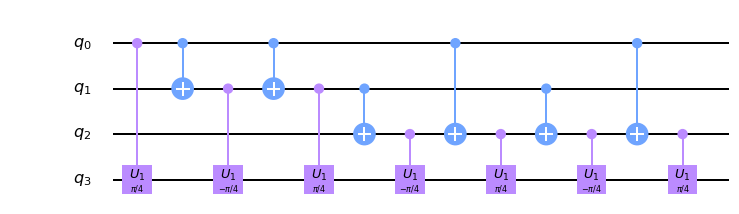

In [784]:
circ = QuantumCircuit(4, name='cccZ')

circ.cu1(pi/4, 0, 3)
circ.cx(0, 1)
circ.cu1(-pi/4, 1, 3)
circ.cx(0, 1)
circ.cu1(pi/4, 1, 3)
circ.cx(1, 2)
circ.cu1(-pi/4, 2, 3)
circ.cx(0, 2)
circ.cu1(pi/4, 2, 3)
circ.cx(1, 2)
circ.cu1(-pi/4, 2, 3)
circ.cx(0, 2)
circ.cu1(pi/4, 2, 3)

cccZ = circ.to_instruction()

circ.draw()

### Wyrocznia
#### wyróżniająca liczbę 2

Po przejściu przez wyrocznię szukana liczba jest oznaczana poprzez znak przeciwny do pozostałych amplitud.

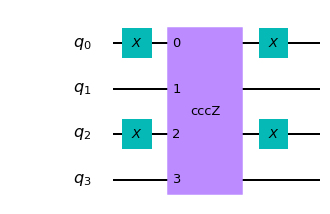

In [785]:
circ = QuantumCircuit(4, name='oracle')
circ.x(0)
circ.x(2)

circ.append(cccZ,[0,1,2,3])
circ.x(0)
circ.x(2)


oracle = circ.to_instruction()

circ.draw()

### Inwersja

Inwersja wzmacnia amplitudę oznaczoną przez wyrocznię.

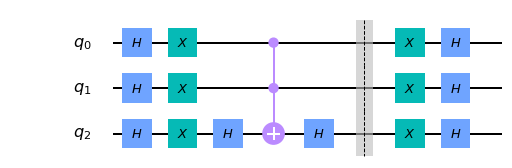

In [786]:
circ = QuantumCircuit(3, name='inversion')

circ.h(0)
circ.h(1)
circ.h(2)
# circ.h(3)

circ.x(0)
circ.x(1)
circ.x(2)
# circ.x(3)

circ.h(2)
# circ.append(cccZ,[0,1,2,3])
circ.toffoli(0,1,2)
circ.h(2)

circ.barrier()

circ.x(0)
circ.x(1)
circ.x(2)
# circ.x(3)

circ.h(0)
circ.h(1)
circ.h(2)
# circ.h(3)

inversion = circ.to_instruction()

circ.draw()

In [787]:
def printAmps(circ, i, j):
    from qiskit import Aer
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()

    ket = result.get_statevector(circ, decimals=6)

    print("Amplitudy po {} {}:".format(i, j))
    for amplitude in ket:
        print(amplitude)
    print("")

In [788]:
# noinspection JupyterKernel
circ = QuantumCircuit(4)
circ.x(3)
circ.barrier()
circ.h(0)
circ.h(1)
circ.h(2)
circ.h(3)
circ.barrier()

for i in range(1, iteracje+1):
    # wyrocznia
    circ.append(oracle,[0,1,2,3])
    circ.h(3)
    circ.barrier()
    printAmps(circ, i, 'wyroczni')
    circ.h(3)
    circ.barrier()
    # inwersja
    circ.append(inversion,[0,1,2])
    printAmps(circ, i, 'inwersji')
    
circ.barrier()
# neguję rejestr wyjściowy, aby w wyniku symulacji dostać szukaną liczbę nie powiększoną o 8
circ.x(3)
print("")

Amplitudy po 1 wyroczni:
0j
0j
(0.353553-0j)
0j
0j
0j
0j
0j
(0.353553-0j)
(0.353553-0j)
(-0+0j)
(0.353553-0j)
(0.353553-0j)
(0.353553-0j)
(0.353553-0j)
(0.353553-0j)

Amplitudy po 1 inwersji:
(-0.25+0j)
(-0.25+0j)
(-0.25+0j)
(-0.25+0j)
(-0.25+0j)
(-0.25+0j)
(-0.25+0j)
(-0.25+0j)
(0.125-0j)
(0.125-0j)
(0.625-0j)
(0.125-0j)
(0.125-0j)
(0.125-0j)
(0.125-0j)
(0.125-0j)

Amplitudy po 2 wyroczni:
(-0.088388+0j)
(-0.088388+0j)
(-0.618718+0j)
(-0.088388+0j)
(-0.088388+0j)
(-0.088388+0j)
(-0.088388+0j)
(-0.088388+0j)
(-0.265165+0j)
(-0.265165+0j)
(0.265165-0j)
(-0.265165+0j)
(-0.265165+0j)
(-0.265165+0j)
(-0.265165+0j)
(-0.265165+0j)

Amplitudy po 2 inwersji:
(0.25-0j)
(0.25-0j)
(0.25-0j)
(0.25-0j)
(0.25-0j)
(0.25-0j)
(0.25-0j)
(0.25-0j)
(0.0625-0j)
(0.0625-0j)
(-0.6875+0j)
(0.0625-0j)
(0.0625-0j)
(0.0625-0j)
(0.0625-0j)
(0.0625-0j)




Po pierwszej wyroczni obserwujemy oznaczenie amplitudy szukanej liczby minusem, podczas gdy pozostałe amplitudy są dodatnie.
Pierwsza inwersja wzmacnia amplitudę wskazaną przez wyrocznię.
Z dokonanych obliczeń wiemy, że dla 3 bitowego rejestru wejściowego potrzebne sa dwie iteracjie Grovera.
Przejście przez wyrocznię ponownie oznacza minusem wyróżnioną amplitude.
Kolejna iteracja wzmacnia, już tylko nieznacznie, wskazaną amplitudę.

### Cały algorytm Grovera
dodatkowa negacja rejestru wyjściowego pozwala na bezpośrednie odczytanie wyniku z wykresu

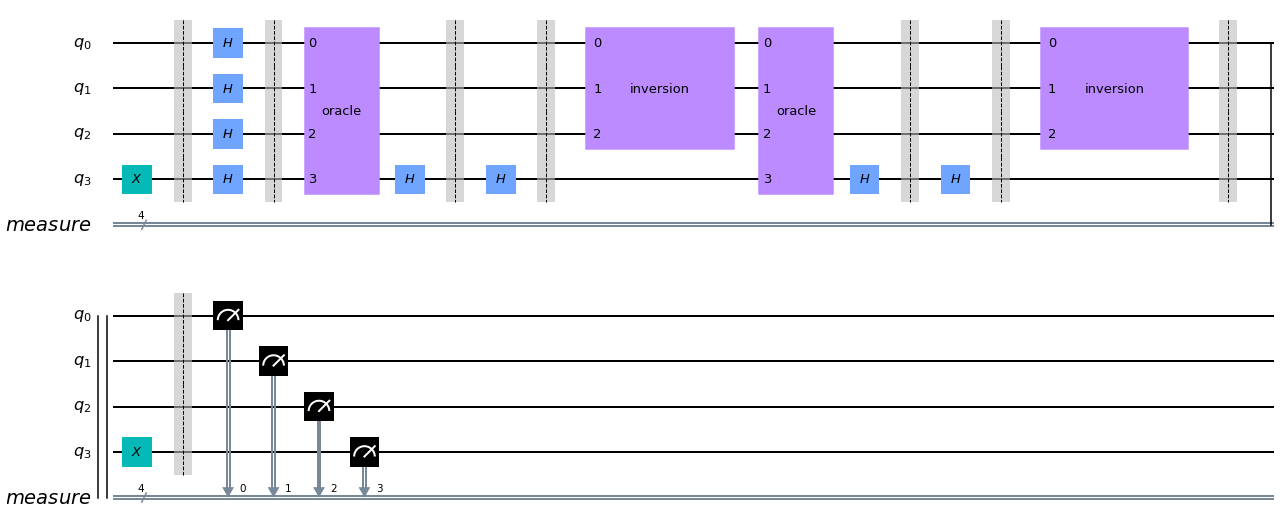

In [789]:
circ.measure_all()

circ.draw()


### Wyniki symulacji

{'1010': 282, '0010': 1926, '1101': 281, '1000': 254, '1111': 282, '0001': 23, '0011': 13, '1001': 233, '0110': 9, '1011': 240, '0000': 22, '0101': 20, '0111': 11, '1100': 255, '1110': 231, '0100': 14}


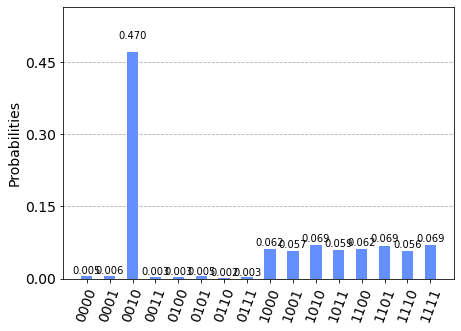

In [790]:


backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(circ, backend_sim, shots=shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

Wynik symulacji jest zgodny z oczekiwaniem. Algorytm po 2 iteracjach znalazł właściwe rozwiązanie - oznaczona przez wyrocznię była liczba 2.

